In [26]:
import tqdm, numpy as np
import matplotlib.pyplot as plt
import utils
import umap
import hdbscan
import matplotlib.pyplot as plt
import logging
from bson.objectid import ObjectId
import gc
import tasks

In [27]:
# for jupyter notebook widgets
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display
%matplotlib inline

In [28]:
# connect to database
db = utils.connect()
db

Database(MongoClient(host=['20.220.215.35:27017'], document_class=dict, tz_aware=False, connect=True, authsource='admin', authmechanism='SCRAM-SHA-256', connecttimeoutms=50000, serverselectiontimeoutms=50000, directconnection=True, replicaset='rs0'), 'aita')

In [29]:
# just hardcoded my groups here, will be replaced with user-provided groups in final version
group_id_strings = ['63901a89e189962b660959cf', '63901a92931eeac91c9924a1', '63901a96e189962b660959d3']
group_id_strings

['63901a89e189962b660959cf',
 '63901a92931eeac91c9924a1',
 '63901a96e189962b660959d3']

In [30]:
# convert to objectId's
group_ids = [ObjectId(str(id)) for id in group_id_strings]
group_ids

[ObjectId('63901a89e189962b660959cf'),
 ObjectId('63901a92931eeac91c9924a1'),
 ObjectId('63901a96e189962b660959d3')]

In [31]:
# retrieve groups from database
groups = list(db.groups.find({"_id":{"$in" : group_ids}}))
print("Retrieved " + str(len(groups)) + " groups from database")
groups[0]

Retrieved 3 groups from database


{'_id': ObjectId('63901a89e189962b660959cf'),
 'creation_time': datetime.datetime(2022, 12, 7, 4, 46, 1, 46000),
 'teleoscope': ObjectId('63901a89e189962b660959ce'),
 'history': [{'timestamp': datetime.datetime(2022, 12, 7, 4, 46, 57, 928000),
   'color': '#49fc81',
   'included_documents': ['hetv62', 'lwd55z', 'dhbdpv', 'eyj0sv'],
   'label': 'wifi',
   'action': 'Add document to group',
   'user': ObjectId('6388e6b38459944ec87d4ce1')},
  {'timestamp': datetime.datetime(2022, 12, 7, 4, 46, 53, 689000),
   'color': '#49fc81',
   'included_documents': ['hetv62', 'lwd55z', 'dhbdpv'],
   'label': 'wifi',
   'action': 'Add document to group',
   'user': ObjectId('6388e6b38459944ec87d4ce1')},
  {'timestamp': datetime.datetime(2022, 12, 7, 4, 46, 51, 856000),
   'color': '#49fc81',
   'included_documents': ['hetv62', 'lwd55z'],
   'label': 'wifi',
   'action': 'Add document to group',
   'user': ObjectId('6388e6b38459944ec87d4ce1')},
  {'timestamp': datetime.datetime(2022, 12, 7, 4, 46, 47, 

In [32]:
# default to ordering documents relative to first group's teleoscope
teleoscope_oid = groups[0]["teleoscope"]
teleoscope_oid

ObjectId('63901a89e189962b660959ce')

In [33]:
teleoscope = db.teleoscopes.find_one({"_id": ObjectId(str(teleoscope_oid))})
#teleoscope

In [34]:
# get Teleoscope from GridFS
all_ordered_documents = utils.gridfsDownload(db, "teleoscopes", ObjectId(str(teleoscope["history"][0]["ranked_document_ids"])))
len(all_ordered_documents)

347807

In [35]:
# grab only subset of the ordered documents
limit = 10000
# TODO: does this line generate an out of bounds access?
ordered_documents = all_ordered_documents[0:limit]
limit = min(limit, len(ordered_documents))
limit

10000

In [36]:
# projection here to only include the fields we want
projection = {'id': 1, 'textVector': 1}
projection

{'id': 1, 'textVector': 1}

In [37]:
# cursor is a generator which means it yields a new doc one at a time
cursor = db.documents.find(
    # query
    {"id":{"$in": [document[0] for document in ordered_documents]}},
    projection=projection,
    # batch size means number of documents at a time taken from MDB, no impact on iteration
    batch_size=500
)
cursor

In [31]:
# sanity check inspection
#doc_cursor = list(cursor)
#len(doc_cursor)

10000

In [38]:
document_ids = []
document_vectors = []

# for large datasets, this will take a while. Would be better to find out whether the UMAP fns can 
# accept generators for lazy calculation
for document in tqdm.tqdm(cursor, total=limit):
    document_ids.append(document["id"])
    document_vectors.append(document["textVector"])

print("There are " + str(len(document_ids)) + " document ids.")
print("There are " + str(len(document_vectors)) + " document vectors.")
document_ids[0:10]

100%|███████████████████████████████████████████████| 10000/10000 [00:28<00:00, 345.48it/s]

There are 10000 document ids.
There are 10000 document vectors.


['21igkp',
 '26zxmf',
 '27a8m9',
 '2frddy',
 '2g98q4',
 '2h2jy7',
 '2mg9gm',
 '2oh4y3',
 '2uxd8a',
 '2xm9hc']

In [39]:
data = np.array(document_vectors)
data.shape

(10000, 512)

In [40]:
# initialize labels to array of -1 for each document
# assume a sparse labeling scheme
labels = np.full(data.shape[0], -1)
print(labels.shape)
labels[0:10]

(10000,)


array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [41]:
label = 1
# add the correct labels to the label np.array
total_tagged = 0
cluster_stats_dict = {}

In [42]:
sample_group = groups[0:1]
print(len(sample_group))
for group in sample_group:
    print(group["history"][0]["included_documents"])

1
['hetv62', 'lwd55z', 'dhbdpv', 'eyj0sv']


In [44]:
for group in groups:
    label_count = 0
    # grab latest history item for each group
    group_document_ids = group["history"][0]["included_documents"]
    # save cluster label just in case (not pushed to mongoDB, only for local computation)
    group["label"] = label
    print("The following documents were in the group with label " + str(label) + ": ", group_document_ids)
    
    indices = []
    for id in group_document_ids:
        try:
            index = document_ids.index(id)
            indices.append(index)
        except:
            document = db.documents.find_one({"id": id}, projection=projection)
            document_ids.append(id)
            vector = np.array(document["textVector"]).reshape((1, 512))
            data = np.append(data, vector, axis=0)
            labels = np.append(labels, -1)
            
            index = document_ids.index(id)
            indices.append(index)
            
    print("Document ids has the shape: ", len(document_ids))
    print("The data has shape: ", data.shape)
    print("The manual labels have shape: ", labels.shape)
    
    print(indices)
    
    # add labels
    for i in indices:
        labels[i] = label
    
    # stats for this particular label
    label_count = np.count_nonzero(labels == label)
    coverage = (label_count/len(data))*100
    total_tagged = total_tagged + label_count
    cluster_stats_dict[label] = label_count
    label = label + 1

print(cluster_stats_dict)

The following documents were in the group with label 1:  ['hetv62', 'lwd55z', 'dhbdpv', 'eyj0sv']
Document ids has the shape:  10000
The data has shape:  (10000, 512)
The manual labels have shape:  (10000,)
[5630, 7789, 2801, 3965]
The following documents were in the group with label 2:  ['g3y7dc', 'j8nzf5', 'fs0vuw', 'q9zlgr', 'ia4w5v', 'ruuxs1', 'hw16a9']
Document ids has the shape:  10005
The data has shape:  (10005, 512)
The manual labels have shape:  (10005,)
[10000, 10001, 10002, 10003, 6135, 9393, 10004]
The following documents were in the group with label 3:  ['mnqbp9', 'spk73c', 'qqwzth', 'dfon3v', 'bqafew']
Document ids has the shape:  10010
The data has shape:  (10010, 512)
The manual labels have shape:  (10010,)
[10005, 10006, 10007, 10008, 10009]
{1: 4, 2: 7, 3: 5}


In [25]:
print(document_ids[5630], document_ids[7789], document_ids[2801], document_ids[3965])
print(labels[5630], labels[7789], labels[2801], labels[3965])

hetv62 lwd55z dhbdpv eyj0sv
1 1 1 1


In [45]:
fitter = umap.UMAP(verbose=True, low_memory=True).fit(data, y=labels)

UMAP( verbose=True)
Thu Dec  8 10:37:05 2022 Construct fuzzy simplicial set
Thu Dec  8 10:37:05 2022 Finding Nearest Neighbors
Thu Dec  8 10:37:05 2022 Building RP forest with 10 trees
Thu Dec  8 10:37:08 2022 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	Stopping threshold met -- exiting after 5 iterations
Thu Dec  8 10:37:13 2022 Finished Nearest Neighbor Search
Thu Dec  8 10:37:14 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu Dec  8 10:37:18 2022 Finished embedding


In [46]:
embedding = fitter.embedding_

In [47]:
umap_embeddings = fitter.transform(data)

In [64]:
@widgets.interact_manual(min_samples(1,100), min_cluster_size(100, 10000))
def cluster(min_samples=10, min_cluster_size=500):
    hdbscan_labels = hdbscan.HDBSCAN(min_samples, min_cluster_size).fit_predict(umap_embeddings)

TypeError: 'int' object is not callable

In [48]:
# should find a way to let user parameterize these
hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500).fit_predict(umap_embeddings)

In [49]:
hdbscan_labels[0:100]

array([ 2,  2, -1,  3, -1,  0,  2, -1,  2, -1,  2,  0,  2, -1,  2, -1,  2,
        0,  0,  2, -1,  0,  0, -1, -1,  2, -1,  2,  2, -1,  2,  3,  2, -1,
       -1,  0,  2,  2,  2,  2,  0,  3, -1,  2,  2, -1,  3, -1,  2,  2,  2,
       -1, -1,  2,  0, -1, -1, -1,  4,  2,  2,  3,  0,  2,  2,  1,  1,  2,
        2,  2, -1, -1, -1,  2,  3, -1,  0,  2, -1, -1, -1,  2, -1,  2,  2,
        2, -1,  1,  0,  3, -1,  4, -1,  0,  2,  2,  2, -1, -1,  2])

In [50]:
set(hdbscan_labels)

{-1, 0, 1, 2, 3, 4}

In [51]:
label_array = np.array(hdbscan_labels)

In [52]:
cluster_label_dict = {}
for cluster_label in set(hdbscan_labels):
    cluster_label_dict[cluster_label] = np.count_nonzero(label_array == cluster_label)
cluster_label_dict

{0: 1267, 1: 579, 2: 3210, 3: 978, 4: 523, -1: 3453}

In [60]:
# examine matchings between human labelled clusters and machine labelled clusters
group_1 = [5630, 7789, 2801, 3965]
group_2 = [10000, 10001, 10002, 10003, 6135, 9393, 10004]
group_3 = [10005, 10006, 10007, 10008, 10009]
groups = [group_1, group_2, group_3]
for group in groups:
    print(f'Displaying post id, human label, and HDBscan label for documents in {group=}')
    for index in group:
        print(document_ids[index], labels[index], hdbscan_labels[index])

Displaying post id, human label, and HDBscan label for documents in group=[5630, 7789, 2801, 3965]
hetv62 1 3
lwd55z 1 3
dhbdpv 1 3
eyj0sv 1 3
Displaying post id, human label, and HDBscan label for documents in group=[10000, 10001, 10002, 10003, 6135, 9393, 10004]
g3y7dc 2 -1
j8nzf5 2 -1
fs0vuw 2 -1
q9zlgr 2 -1
ia4w5v 2 -1
ruuxs1 2 -1
hw16a9 2 -1
Displaying post id, human label, and HDBscan label for documents in group=[10005, 10006, 10007, 10008, 10009]
mnqbp9 3 -1
spk73c 3 -1
qqwzth 3 -1
dfon3v 3 -1
bqafew 3 -1


<Figure size 640x480 with 0 Axes>

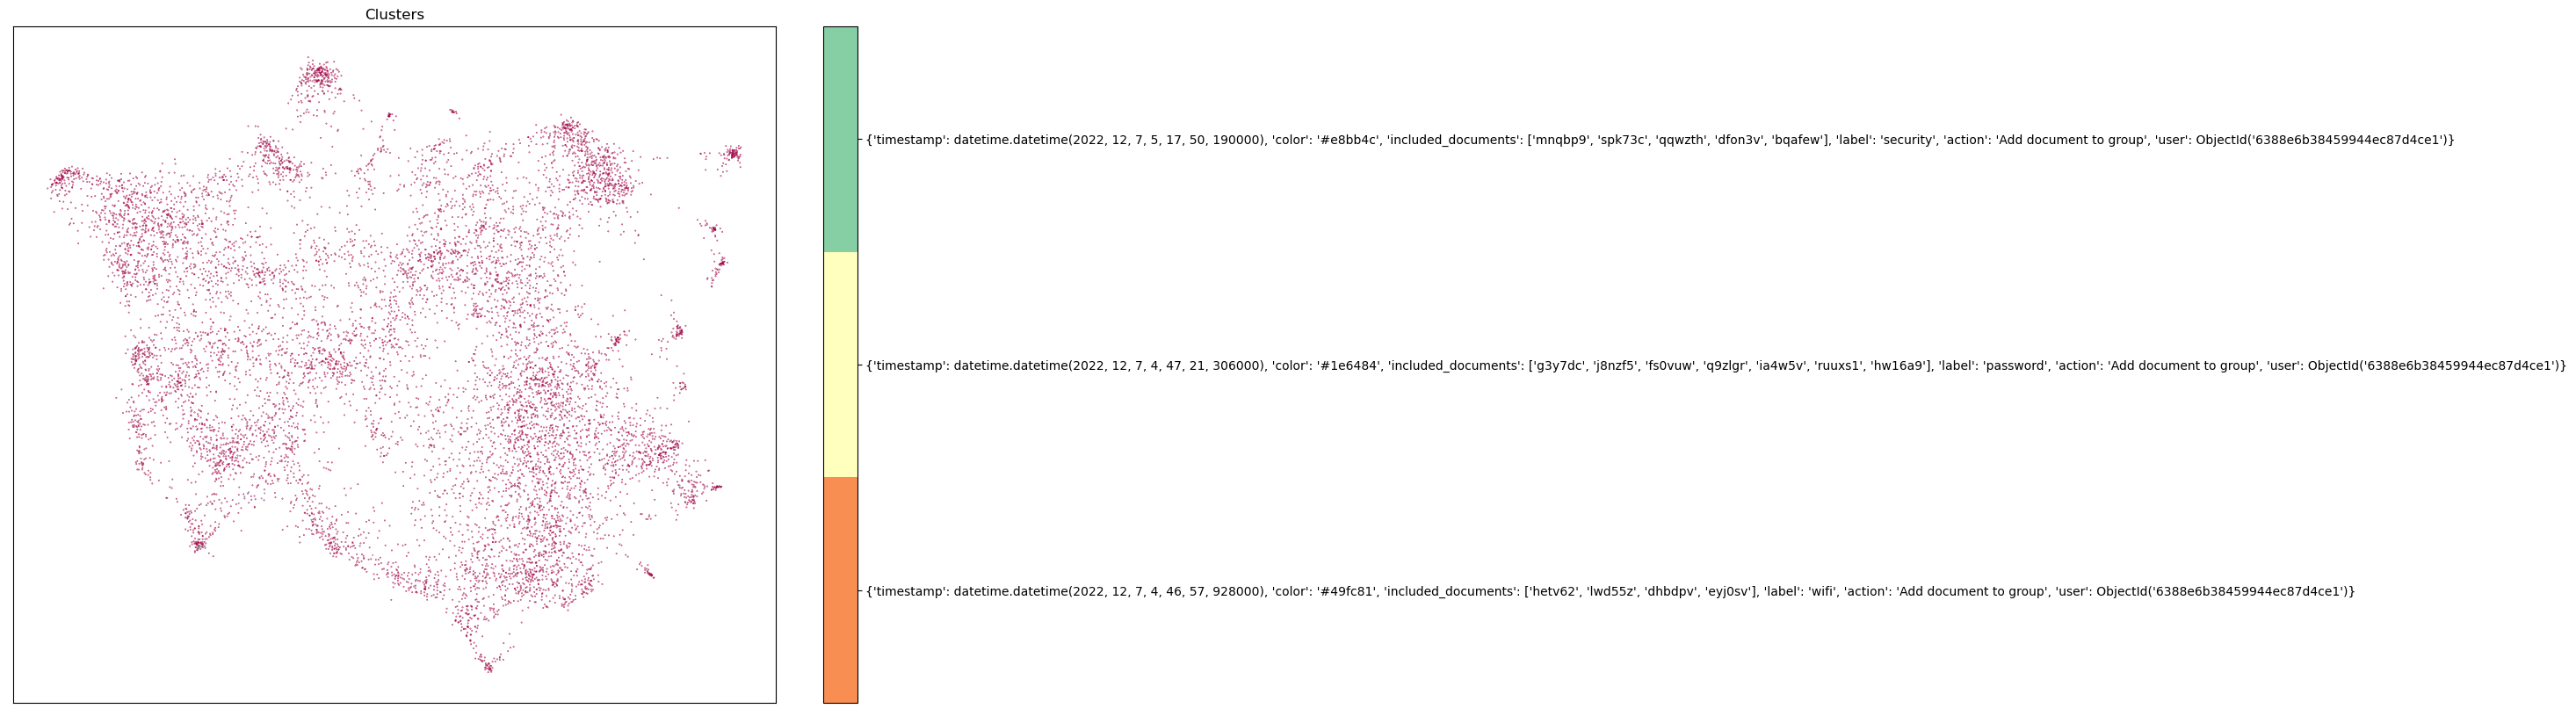

In [55]:
# visualizations
clustered = (hdbscan_labels >= 0)
plt.scatter(umap_embeddings[~clustered, 0],
            umap_embeddings[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(umap_embeddings[clustered, 0],
            umap_embeddings[clustered, 1],
            c=hdbscan_labels[clustered],
            s=0.1,
            cmap='Spectral');

plt.savefig("hdbscan.png")
plt.clf()

labelnames = [group["history"][0] for group in groups]

fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.1, c=labels, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(len(labelnames) + 1)-0.5)
cbar.set_ticks(np.arange(len(labelnames)))
cbar.set_ticklabels(labelnames)
plt.title('Clusters');
fig.savefig('clusters.png', dpi=fig.dpi)
logging.info("Plots saved.")